In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from datetime import datetime

In [ ]:
# 1.375110106	1.367739682	1.404353341	1.421587158 15 yr

# 1.355375737	1.352211434	1.384712741	1.397424019 30yr



In [2]:
# Read the Global Temperature multisource Excel file and the NOAA sheet
file_path = '/data/keeling/a/sudhansu/i/GlobalTempChange/GlobalTemprature_MultiSource.xlsx'

# Read the data from the Excel file
df_noaa = pd.read_excel(file_path, sheet_name='NOAA', usecols="A:B")
df_crut = pd.read_excel(file_path, sheet_name='HadCRUT_5.0.2.0', usecols="A:B")
df_berkeley = pd.read_excel(file_path, sheet_name='Berkeley-earth-temperature', usecols="A:B")
df_NASA = pd.read_excel(file_path, sheet_name='NASA', usecols="A:B")
df_DCENT = pd.read_excel(file_path, sheet_name='DCENT', usecols="A:B")


# Adjustment = Anerage anomaly 1950-1980
df_base_noaa = df_noaa[(df_noaa['Year'] >= 1850) & (df_noaa['Year'] <= 1900)]
Adjustment_noaa = df_base_noaa['Anomaly(1901-2000 baseline)'].mean()

df_base_crut = df_crut[(df_crut['Time'] >= 1850) & (df_crut['Time'] <= 1900)]
Adjustment_crut = df_base_crut['Anomaly (1961-1990 baseline deg C)'].mean()

df_base_berkeley = df_berkeley[(df_berkeley['Year'] >= 1850) & (df_berkeley['Year'] <= 1900)]
Adjustment_berkeley = df_base_berkeley['Annual_Anomaly(1951-Dec 1980 baseline)'].mean()

df_NASA_1880to1900_avg = df_NASA[(df_NASA['Year'] >= 1880) & (df_NASA['Year'] <= 1900)]['Anomaly(1951-1980 baseline)'].mean()
Adjustment_NASA = df_NASA_1880to1900_avg - 0.03 # As suggested by Gavin Schmidt and Ken Kunkel to bring NASA data to 1850-1900 baseline

df_base_DCENT = df_DCENT[(df_DCENT['Year'] >= 1850) & (df_DCENT['Year'] <= 1900)]
Adjustment_DCENT = df_base_DCENT['GMST (1850ー1900 baseline °C)'].mean()


# Perfor Adjustment to make all data source at 1850-1900 baseline

df_noaa['Anomaly(1850-1900 baseline)'] = df_noaa['Anomaly(1901-2000 baseline)'] - Adjustment_noaa
df_crut['Anomaly(1850-1900 baseline)'] = df_crut['Anomaly (1961-1990 baseline deg C)'] - Adjustment_crut
df_berkeley['Anomaly(1850-1900 baseline)'] = df_berkeley['Annual_Anomaly(1951-Dec 1980 baseline)'] - Adjustment_berkeley
df_NASA['Anomaly(1850-1900 baseline)'] = df_NASA['Anomaly(1951-1980 baseline)'] - Adjustment_NASA
df_DCENT['Anomaly(1850-1900 baseline)'] = df_DCENT['GMST (1850ー1900 baseline °C)'] - Adjustment_DCENT

df_DCENT

,Year,GMST (1850ー1900 baseline °C),Anomaly(1850-1900 baseline)
0,1850,-1.02,-0.181569
1,1851,-0.87,-0.031569
2,1852,-0.84,-0.001569
3,1853,-0.87,-0.031569
4,1854,-0.88,-0.041569
...,...,...,...
169,2019,0.52,1.358431
170,2020,0.54,1.378431
171,2021,0.41,1.248431
172,2022,0.43,1.268431


In [3]:
# Initialize lists to store the coefficients for the quadratic regression
coefficients_noaa = []
window_size = 30
index0_year = 1849
# Loop through the dataframe starting from 1994
for start_year in range(1995, df_noaa['Year'].max() - window_size + 2):
    end_year = start_year + window_size - 1
    df_window_noaa = df_noaa[(df_noaa['Year'] >= start_year) & (df_noaa['Year'] <= end_year)]
    # Perform quadratic regression
    coeffs = np.polyfit(df_window_noaa.index + 1, df_window_noaa['Anomaly(1850-1900 baseline)'], 2)
    
    # Append the results to the list
    coefficients_noaa.append(coeffs)

# Create a new dataframe to store the results
df_quadratic_regression_noaa = pd.DataFrame({
    'Start Year': range(1995, df_noaa['Year'].max() - window_size + 2),
    'End Year': range(1995 + window_size - 1, df_noaa['Year'].max() + 1),
    'a': [coeff[0] for coeff in coefficients_noaa],
    'b': [coeff[1] for coeff in coefficients_noaa],
    'c': [coeff[2] for coeff in coefficients_noaa]
})

# Extract the coefficients for the year 2023
coeffs_2024_noaa = df_quadratic_regression_noaa[df_quadratic_regression_noaa['End Year'] == 2024].iloc[0]
a_2024_noaa = coeffs_2024_noaa['a']
b_2024_noaa = coeffs_2024_noaa['b']
c_2024_noaa = coeffs_2024_noaa['c']

# Compute the anomaly values for the years 2024 to 2100 using the quadratic trend
new_anomalies_noaa = []
for year in range(2025, 2101):
    anomaly = a_2024_noaa * (year - index0_year)**2 + b_2024_noaa * (year - index0_year) + c_2024_noaa
    new_anomalies_noaa.append({'Year': year, 'Anomaly(1850-1900 baseline)': anomaly})

# Convert the list to a DataFrame
df_new_anomalies_noaa = pd.DataFrame(new_anomalies_noaa)

# Append the new anomaly values to the existing df_noaa DataFrame
df_noaa = pd.concat([df_noaa, df_new_anomalies_noaa], ignore_index=True)

# Compute the 11-year centered average
df_noaa['11yr_centered_avg'] = df_noaa['Anomaly(1850-1900 baseline)'].rolling(window=11, center=True).mean()

# Compute the 21-year centered average
df_noaa['21yr_centered_avg'] = df_noaa['Anomaly(1850-1900 baseline)'].rolling(window=21, center=True).mean()

# Compute the 31-year centered average starting at 2010 onwards for df_noaa
df_noaa['31yr_centered_avg'] = df_noaa['Anomaly(1850-1900 baseline)'].rolling(window=31, center=True).mean()

# Display the updated DataFrame
df_noaa.tail(50)

,Year,Anomaly(1901-2000 baseline),Anomaly(1850-1900 baseline),11yr_centered_avg,21yr_centered_avg,31yr_centered_avg
201,2051,NaN,2.797811,2.803445,2.818468,2.842881
202,2052,NaN,2.868500,2.874134,2.889157,2.913570
203,2053,NaN,2.940317,2.945950,2.960974,2.985386
204,2054,NaN,3.013259,3.018893,3.033916,3.058329
205,2055,NaN,3.087329,3.092963,3.107986,3.132399
206,2056,NaN,3.162525,3.168159,3.183182,3.207595
207,2057,NaN,3.238848,3.244482,3.259506,3.283918
208,2058,NaN,3.316298,3.321932,3.336955,3.361368
209,2059,NaN,3.394875,3.400509,3.415532,3.439945
210,2060,NaN,3.474578,3.480212,3.495235,3.519648


In [4]:
# Initialize lists to store the coefficients for the quadratic regression
coefficients_crut = []
window_size = 30
index0_year = 1849

# Loop through the dataframe starting from 1994
for start_year in range(1995, df_crut['Time'].max() - window_size + 2):
    end_year = start_year + window_size - 1
    df_window_crut = df_crut[(df_crut['Time'] >= start_year) & (df_crut['Time'] <= end_year)]
    # Perform quadratic regression
    coeffs = np.polyfit(df_window_crut.index + 1, df_window_crut['Anomaly(1850-1900 baseline)'], 2)
    
    # Append the results to the list
    coefficients_crut.append(coeffs)

# Create a new dataframe to store the results
df_quadratic_regression_crut = pd.DataFrame({
    'Start Year': range(1995, df_crut['Time'].max() - window_size + 2),
    'End Year': range(1995 + window_size - 1, df_crut['Time'].max() + 1),
    'a': [coeff[0] for coeff in coefficients_crut],
    'b': [coeff[1] for coeff in coefficients_crut],
    'c': [coeff[2] for coeff in coefficients_crut]
})

# Extract the coefficients for the year 2023
coeffs_2024_crut = df_quadratic_regression_crut[df_quadratic_regression_crut['End Year'] == 2024].iloc[0]
a_2024_crut = coeffs_2024_crut['a']
b_2024_crut = coeffs_2024_crut['b']
c_2024_crut = coeffs_2024_crut['c']

# Compute the anomaly values for the years 2024 to 2100 using the quadratic trend
new_anomalies_crut = []
for year in range(2025, 2101):
    anomaly = a_2024_crut * (year - index0_year)**2 + b_2024_crut * (year - index0_year) + c_2024_crut
    new_anomalies_crut.append({'Year': year, 'Anomaly(1850-1900 baseline)': anomaly})

# Convert the list to a DataFrame
df_new_anomalies_crut = pd.DataFrame(new_anomalies_crut)

# Append the new anomaly values to the existing df_crut DataFrame
# df_crut = pd.concat([df_crut, df_new_anomalies_crut], ignore_index=True)
df_crut = pd.concat([df_crut, df_new_anomalies_crut.rename(columns={'Year': 'Time'})], ignore_index=True)

# Compute the 11-year centered average
df_crut['11yr_centered_avg'] = df_crut['Anomaly(1850-1900 baseline)'].rolling(window=11, center=True).mean()

# Compute the 21-year centered average
df_crut['21yr_centered_avg'] = df_crut['Anomaly(1850-1900 baseline)'].rolling(window=21, center=True).mean()

# Compute the 31-year centered average starting at 2010 onwards for df_crut
df_crut['31yr_centered_avg'] = df_crut['Anomaly(1850-1900 baseline)'].rolling(window=31, center=True).mean()

# Display the updated DataFrame
df_crut.tail(50)

,Time,Anomaly (1961-1990 baseline deg C),Anomaly(1850-1900 baseline),11yr_centered_avg,21yr_centered_avg,31yr_centered_avg
201,2051,NaN,2.780555,2.785663,2.799285,2.821421
202,2052,NaN,2.846096,2.851204,2.864826,2.886962
203,2053,NaN,2.912659,2.917767,2.931390,2.953525
204,2054,NaN,2.980244,2.985352,2.998974,3.021110
205,2055,NaN,3.048850,3.053959,3.067581,3.089717
206,2056,NaN,3.118479,3.123587,3.137209,3.159345
207,2057,NaN,3.189128,3.194237,3.207859,3.229995
208,2058,NaN,3.260800,3.265908,3.279530,3.301666
209,2059,NaN,3.333493,3.338601,3.352223,3.374359
210,2060,NaN,3.407208,3.412316,3.425938,3.448074


In [5]:
# Initialize lists to store the coefficients for the quadratic regression
coefficients_berkeley = []
window_size = 30
index0_year = 1849
# Loop through the dataframe starting from 1994
for start_year in range(1995, df_berkeley['Year'].max() - window_size + 2):
    end_year = start_year + window_size - 1
    df_window_berkeley = df_berkeley[(df_berkeley['Year'] >= start_year) & (df_berkeley['Year'] <= end_year)]
    # Perform quadratic regression
    coeffs = np.polyfit(df_window_berkeley.index + 1, df_window_berkeley['Anomaly(1850-1900 baseline)'], 2)
    
    # Append the results to the list
    coefficients_berkeley.append(coeffs)

# Create a new dataframe to store the results
df_quadratic_regression_berkeley = pd.DataFrame({
    'Start Year': range(1995, df_berkeley['Year'].max() - window_size + 2),
    'End Year': range(1995 + window_size - 1, df_berkeley['Year'].max() + 1),
    'a': [coeff[0] for coeff in coefficients_berkeley],
    'b': [coeff[1] for coeff in coefficients_berkeley],
    'c': [coeff[2] for coeff in coefficients_berkeley]
})

# Extract the coefficients for the year 2023
coeffs_2024_berkeley = df_quadratic_regression_berkeley[df_quadratic_regression_berkeley['End Year'] == 2024].iloc[0]
a_2024_berkeley = coeffs_2024_berkeley['a']
b_2024_berkeley = coeffs_2024_berkeley['b']
c_2024_berkeley = coeffs_2024_berkeley['c']

# Compute the anomaly values for the years 2024 to 2100 using the quadratic trend
new_anomalies_berkeley = []
for year in range(2025, 2101):
    anomaly = a_2024_berkeley * (year - index0_year)**2 + b_2024_berkeley * (year - index0_year) + c_2024_berkeley
    new_anomalies_berkeley.append({'Year': year, 'Anomaly(1850-1900 baseline)': anomaly})

# Convert the list to a DataFrame
df_new_anomalies_berkeley = pd.DataFrame(new_anomalies_berkeley)

# Append the new anomaly values to the existing df_berkeley DataFrame
df_berkeley = pd.concat([df_berkeley, df_new_anomalies_berkeley], ignore_index=True)

# Compute the 11-year centered average
df_berkeley['11yr_centered_avg'] = df_berkeley['Anomaly(1850-1900 baseline)'].rolling(window=11, center=True).mean()

# Compute the 21-year centered average
df_berkeley['21yr_centered_avg'] = df_berkeley['Anomaly(1850-1900 baseline)'].rolling(window=21, center=True).mean()

# Compute the 31-year centered average starting at 2010 onwards for df_berkeley
df_berkeley['31yr_centered_avg'] = df_berkeley['Anomaly(1850-1900 baseline)'].rolling(window=31, center=True).mean()

# Display the updated DataFrame
df_berkeley.tail(50)

,Year,Annual_Anomaly(1951-Dec 1980 baseline),Anomaly(1850-1900 baseline),11yr_centered_avg,21yr_centered_avg,31yr_centered_avg
201,2051,NaN,3.059304,3.065589,3.082351,3.109589
202,2052,NaN,3.135199,3.141485,3.158247,3.185485
203,2053,NaN,3.212352,3.218638,3.235400,3.262638
204,2054,NaN,3.290762,3.297048,3.313810,3.341048
205,2055,NaN,3.370430,3.376715,3.393477,3.420715
206,2056,NaN,3.451354,3.457640,3.474401,3.501639
207,2057,NaN,3.533535,3.539821,3.556583,3.583821
208,2058,NaN,3.616974,3.623260,3.640021,3.667259
209,2059,NaN,3.701670,3.707955,3.724717,3.751955
210,2060,NaN,3.787623,3.793908,3.810670,3.837908


In [48]:
df_quadratic_regression_berkeley

,Start Year,End Year,a,b,c
0,1995,2024,0.000629,-0.178673,13.503302


In [6]:
# Initialize lists to store the coefficients for the quadratic regression
coefficients_nasa = []
window_size = 30
index0_year = 1849

# Loop through the dataframe starting from 1994
for start_year in range(1995, df_NASA['Year'].max() - window_size + 2):
    end_year = start_year + window_size - 1
    df_window_nasa = df_NASA[(df_NASA['Year'] >= start_year) & (df_NASA['Year'] <= end_year)]
    # Perform quadratic regression
    coeffs = np.polyfit(df_window_nasa.index + 1, df_window_nasa['Anomaly(1850-1900 baseline)'], 2)
    
    # Append the results to the list
    coefficients_nasa.append(coeffs)

# Create a new dataframe to store the results
df_quadratic_regression_nasa = pd.DataFrame({
    'Start Year': range(1995, df_NASA['Year'].max() - window_size + 2),
    'End Year': range(1995 + window_size - 1, df_NASA['Year'].max() + 1),
    'a': [coeff[0] for coeff in coefficients_nasa],
    'b': [coeff[1] for coeff in coefficients_nasa],
    'c': [coeff[2] for coeff in coefficients_nasa]
})

# Extract the coefficients for the year 2024
coeffs_2024_nasa = df_quadratic_regression_nasa[df_quadratic_regression_nasa['End Year'] == 2024].iloc[0]
a_2024_nasa = coeffs_2024_nasa['a']
b_2024_nasa = coeffs_2024_nasa['b']
c_2024_nasa = coeffs_2024_nasa['c']

# Compute the anomaly values for the years 2024 to 2100 using the quadratic trend
new_anomalies_nasa = []
for year in range(2025, 2101):
    anomaly = a_2024_nasa * (year - index0_year)**2 + b_2024_nasa * (year - index0_year) + c_2024_nasa
    new_anomalies_nasa.append({'Year': year, 'Anomaly(1850-1900 baseline)': anomaly})

# Convert the list to a DataFrame
df_new_anomalies_nasa = pd.DataFrame(new_anomalies_nasa)

# Append the new anomaly values to the existing df_NASA DataFrame
df_NASA = pd.concat([df_NASA, df_new_anomalies_nasa], ignore_index=True)

# Compute the 11-year centered average
df_NASA['11yr_centered_avg'] = df_NASA['Anomaly(1850-1900 baseline)'].rolling(window=11, center=True).mean()

# Compute the 21-year centered average
df_NASA['21yr_centered_avg'] = df_NASA['Anomaly(1850-1900 baseline)'].rolling(window=21, center=True).mean()

# Compute the 31-year centered average starting at 2010 onwards for df_NASA
df_NASA['31yr_centered_avg'] = df_NASA['Anomaly(1850-1900 baseline)'].rolling(window=31, center=True).mean()

# Display the updated DataFrame
df_NASA

,Year,Anomaly(1951-1980 baseline),Anomaly(1850-1900 baseline),11yr_centered_avg,21yr_centered_avg,31yr_centered_avg
0,1850,NaN,NaN,NaN,NaN,NaN
1,1851,NaN,NaN,NaN,NaN,NaN
2,1852,NaN,NaN,NaN,NaN,NaN
3,1853,NaN,NaN,NaN,NaN,NaN
4,1854,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
246,2096,NaN,7.046904,NaN,NaN,NaN
247,2097,NaN,7.165335,NaN,NaN,NaN
248,2098,NaN,7.284854,NaN,NaN,NaN
249,2099,NaN,7.405459,NaN,NaN,NaN


In [8]:

window_size = 30
index0_year = 1849
# Initialize lists to store the coefficients for the quadratic regression
coefficients_dcent = []

# Loop through the dataframe starting from 1994
for start_year in range(1994, df_DCENT['Year'].max() - window_size + 2):
    end_year = start_year + window_size - 1
    df_window_dcent = df_DCENT[(df_DCENT['Year'] >= start_year) & (df_DCENT['Year'] <= end_year)]
    # print(df_window_dcent)
    # Perform quadratic regression
    coeffs = np.polyfit(df_window_dcent.index + 1, df_window_dcent['Anomaly(1850-1900 baseline)'], 2)
    
    # Append the results to the list
    coefficients_dcent.append(coeffs)

# Create a new dataframe to store the results
df_quadratic_regression_dcent = pd.DataFrame({
    'Start Year': range(1994, df_DCENT['Year'].max() - window_size + 2),
    'End Year': range(1994 + window_size - 1, df_DCENT['Year'].max() + 1),
    'a': [coeff[0] for coeff in coefficients_dcent],
    'b': [coeff[1] for coeff in coefficients_dcent],
    'c': [coeff[2] for coeff in coefficients_dcent]
})

# Display the dataframe
# df_quadratic_regression_dcent

# Extract the coefficients for the year 2023
coeffs_2023_dcent = df_quadratic_regression_dcent[df_quadratic_regression_dcent['End Year'] == 2023].iloc[0]
a_2023_dcent = coeffs_2023_dcent['a']
b_2023_dcent = coeffs_2023_dcent['b']
c_2023_dcent = coeffs_2023_dcent['c']

# Compute the anomaly values for the years 2024 to 2100 using the quadratic trend
new_anomalies_dcent = []
for year in range(2024, 2101):
    anomaly = a_2023_dcent * (year - index0_year)**2 + b_2023_dcent * (year - index0_year) + c_2023_dcent
    print(anomaly)
    new_anomalies_dcent.append({'Year': year, 'Anomaly(1850-1900 baseline)': anomaly})

# Convert the list to a DataFrame
df_new_anomalies_dcent = pd.DataFrame(new_anomalies_dcent)

# Append the new anomaly values to the existing df_DCENT DataFrame
df_DCENT = pd.concat([df_DCENT, df_new_anomalies_dcent], ignore_index=True)

# Compute the 11-year centered average
df_DCENT['11yr_centered_avg'] = df_DCENT['Anomaly(1850-1900 baseline)'].rolling(window=11, center=True).mean()

# Compute the 21-year centered average
df_DCENT['21yr_centered_avg'] = df_DCENT['Anomaly(1850-1900 baseline)'].rolling(window=21, center=True).mean()

# Compute the 31-year centered average starting at 2010 onwards for df_DCENT
df_DCENT['31yr_centered_avg'] = df_DCENT['Anomaly(1850-1900 baseline)'].rolling(window=31, center=True).mean()

# Display the updated DataFrame
df_DCENT.tail(50)
# df_DCENT.to_excel('/data/keeling/a/sudhansu/i/GlobalTempChange/test.xlsx')

1.4637121607263612
1.4991791875815963
1.53559051763086
1.5729461508741451
1.6112460873114554
1.6504903269427942
1.6906788697681545
1.7318117157875434
1.7738888650009539
1.8169103174083912
1.8608760730098535
1.9057861318053408
1.9516404937948568
1.9984391589783943
2.0461821273559533
2.0948693989275444
2.144500973693157
2.1950768516527948
2.246597032806461
2.299061517154149
2.3524703046958653
2.406823395431603
2.462120789361366
2.5183624864851577
2.5755484868029708
2.6336787903148124
2.6927533970206756
2.752772306920564
2.8137355200144807
2.875643036302419
2.938494855784386
3.0022909784603744
3.0670314043303915
3.1327161333944336
3.199345165652497
3.266918501104593
3.3354361397507066
3.4048980815908454
3.4753043266250163
3.546654874853205
3.6189497262754227
3.692188880891665
3.7663723387019292
3.8415000997062254
3.9175721639045396
3.994588531296886
4.072549201883254
4.151454175663643
4.231303452638064
4.312097032806504
4.393834916168975
4.476517102725468
4.5601435924759866
4.644714385420

,Year,GMST (1850ー1900 baseline °C),Anomaly(1850-1900 baseline),11yr_centered_avg,21yr_centered_avg,31yr_centered_avg
201,2051,NaN,2.752772,2.757494,2.770085,2.790544
202,2052,NaN,2.813736,2.818457,2.831048,2.851508
203,2053,NaN,2.875643,2.880365,2.892955,2.913415
204,2054,NaN,2.938495,2.943216,2.955807,2.976267
205,2055,NaN,3.002291,3.007012,3.019603,3.040063
206,2056,NaN,3.067031,3.071753,3.084344,3.104804
207,2057,NaN,3.132716,3.137438,3.150028,3.170488
208,2058,NaN,3.199345,3.204067,3.216657,3.237117
209,2059,NaN,3.266919,3.271640,3.284231,3.304691
210,2060,NaN,3.335436,3.340158,3.352748,3.373208


In [50]:
coeffs_2023_dcent

Start Year    1994.000000
End Year      2023.000000
a                0.000472
b               -0.130258
c                9.799252
Name: 0, dtype: float64

In [46]:
df_quadratic_regression_dcent

,Start Year,End Year,a,b,c
0,1994,2023,0.000472,-0.130258,9.799252


In [27]:
file_name = f'GlobalTemperature_polyfit_30yrTrend.xlsx'
with pd.ExcelWriter(file_name) as writer:
    df_noaa.to_excel(writer, sheet_name='NOAA', index=False)
    df_crut.to_excel(writer, sheet_name='HadCRUT', index=False)
    df_berkeley.to_excel(writer, sheet_name='Berkeley-Earth-Temperature', index=False)
    df_NASA.to_excel(writer, sheet_name='NASA', index=False)
    df_DCENT.to_excel(writer, sheet_name='DCENT_GlobalTemperature', index=False)

In [10]:
df_noaa

,Year,Anomaly(1901-2000 baseline),Anomaly(1850-1900 baseline),11yr_centered_avg,21yr_centered_avg,31yr_centered_avg
0,1850,-0.20,-0.026275,NaN,NaN,NaN
1,1851,-0.09,0.083725,NaN,NaN,NaN
2,1852,-0.05,0.123725,NaN,NaN,NaN
3,1853,-0.11,0.063725,NaN,NaN,NaN
4,1854,-0.07,0.103725,NaN,NaN,NaN
...,...,...,...,...,...,...
246,2096,NaN,7.094313,NaN,NaN,NaN
247,2097,NaN,7.215707,NaN,NaN,NaN
248,2098,NaN,7.338226,NaN,NaN,NaN
249,2099,NaN,7.461873,NaN,NaN,NaN


### New Composite plot: Polyfit

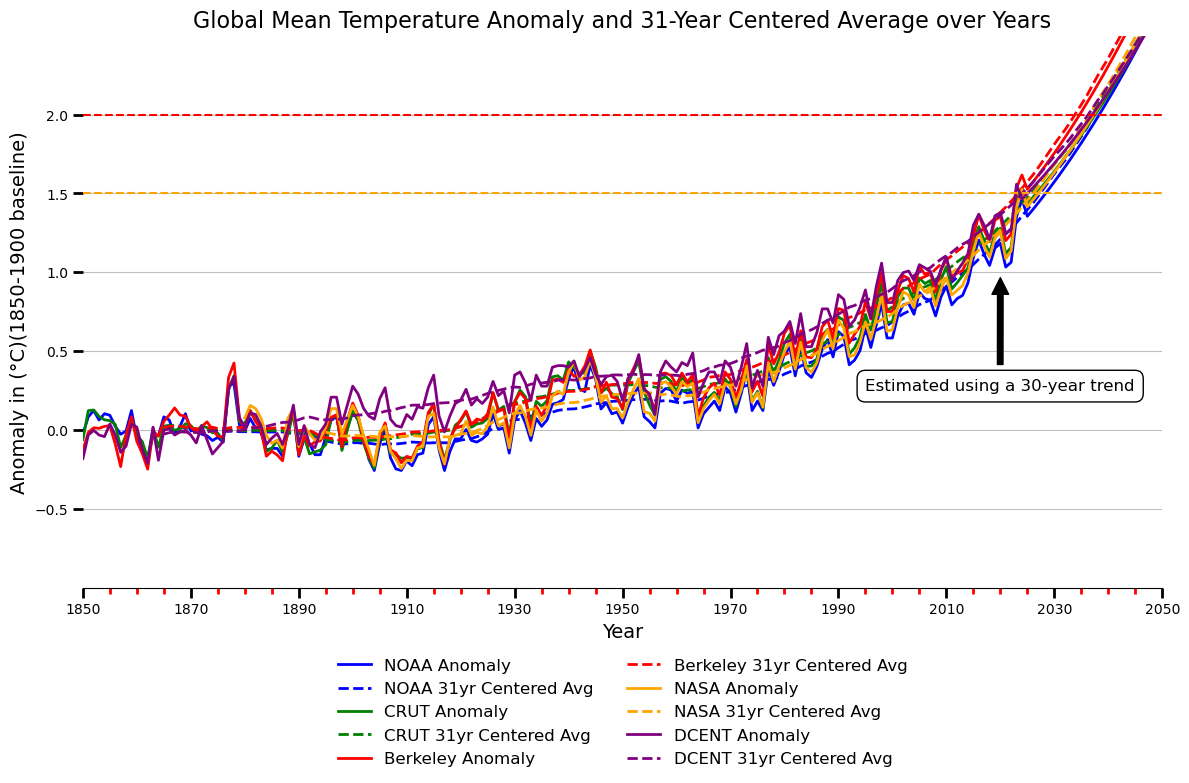

In [9]:
from matplotlib.ticker import AutoMinorLocator

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot df_noaa
plt.plot(df_noaa['Year'], df_noaa['Anomaly(1850-1900 baseline)'], label='NOAA Anomaly', color='blue', linewidth=2)
plt.plot(df_noaa['Year'], df_noaa['31yr_centered_avg'], label='NOAA 31yr Centered Avg', linestyle='--', color='blue', linewidth=2)

# Plot df_crut
plt.plot(df_crut['Time'], df_crut['Anomaly(1850-1900 baseline)'], label='CRUT Anomaly', color='green', linewidth=2)
plt.plot(df_crut['Time'], df_crut['31yr_centered_avg'], label='CRUT 31yr Centered Avg', linestyle='--', color='green', linewidth=2)

# Plot df_berkeley
plt.plot(df_berkeley['Year'], df_berkeley['Anomaly(1850-1900 baseline)'], label='Berkeley Anomaly', color='red', linewidth=2)
plt.plot(df_berkeley['Year'], df_berkeley['31yr_centered_avg'], label='Berkeley 31yr Centered Avg', linestyle='--', color='red', linewidth=2)

# Plot df_NASA
plt.plot(df_NASA['Year'], df_NASA['Anomaly(1850-1900 baseline)'], label='NASA Anomaly', color='orange', linewidth=2)
plt.plot(df_NASA['Year'], df_NASA['31yr_centered_avg'], label='NASA 31yr Centered Avg', linestyle='--', color='orange', linewidth=2)

# Plot df_DCENT
plt.plot(df_DCENT['Year'], df_DCENT['Anomaly(1850-1900 baseline)'], label='DCENT Anomaly', color='purple', linewidth=2)
plt.plot(df_DCENT['Year'], df_DCENT['31yr_centered_avg'], label='DCENT 31yr Centered Avg', linestyle='--', color='purple', linewidth=2)

# Add grid lines
plt.grid(True, linestyle='-', alpha=0.5, axis= 'y', which='both', color='gray')

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.gca().yaxis.set_ticks([])
# Move legend slightly down
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False, fontsize=12)

# Add a horizontal line at y=1.5
plt.axhline(y=1.5, color='orange', linestyle='--', label='y=1.5')

# Add a horizontal line at y=2.0
plt.axhline(y=2.0, color='r', linestyle='--', label='y=2.0')

# Set x-axis limit
plt.xlim([1850, 2050])
plt.ylim([-1, 2.5])

# Set x-axis ticks and labels at 5-year intervals
plt.xticks(range(1850, 2051, 20))

# Set y-axis ticks at 0.5 intervals
plt.yticks([i * 0.5 for i in range(-1, 5)])
# plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())

plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=4, color='r')

# Add title and labels
plt.title('Global Mean Temperature Anomaly and 31-Year Centered Average over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel(u'Anomaly in (\u00B0C)(1850-1900 baseline)', fontsize=14)

# Add annotation
plt.annotate('Estimated using a 30-year trend', xy=(2020, 1), xytext=(1995, 0.25),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, color='black',
             bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

# Show plot
plt.tight_layout()
plt.show()

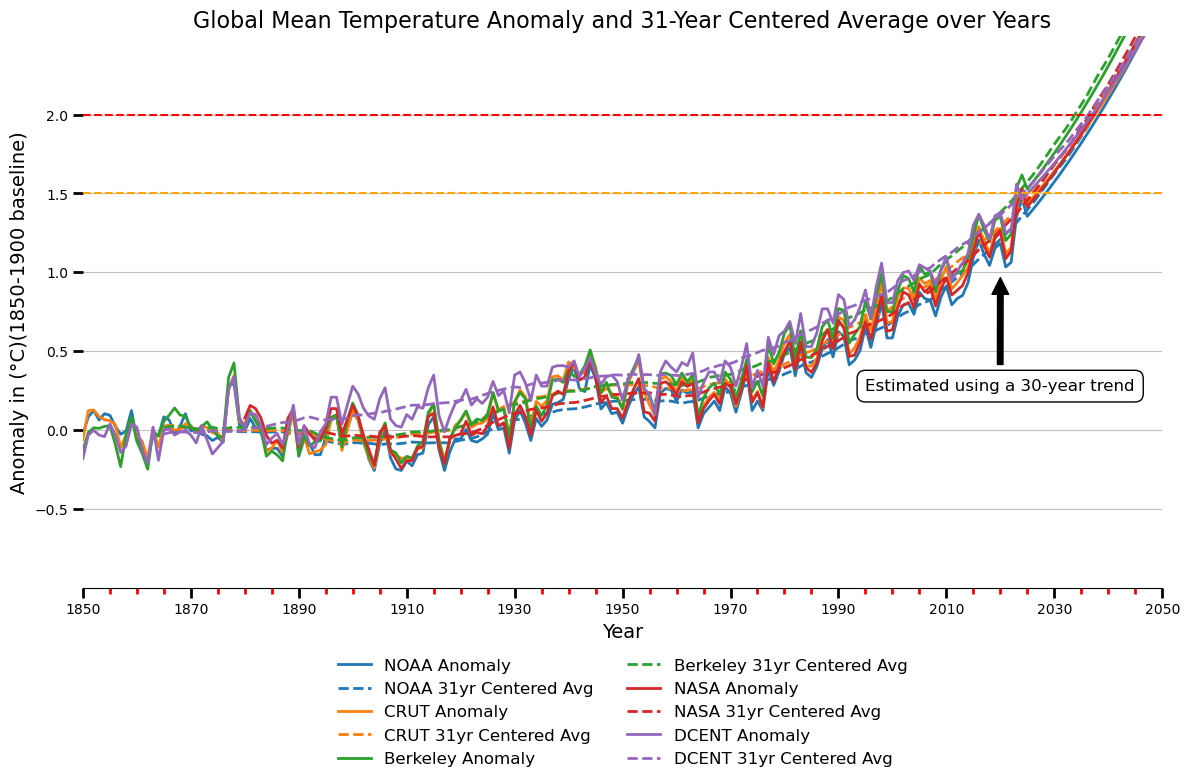

In [11]:
from matplotlib.ticker import AutoMinorLocator

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot df_noaa
plt.plot(df_noaa['Year'], df_noaa['Anomaly(1850-1900 baseline)'], label='NOAA Anomaly', color='#1f77b4', linewidth=2)
plt.plot(df_noaa['Year'], df_noaa['31yr_centered_avg'], label='NOAA 31yr Centered Avg', linestyle='--', color='#1f77b4', linewidth=2)

# Plot df_crut
plt.plot(df_crut['Time'], df_crut['Anomaly(1850-1900 baseline)'], label='CRUT Anomaly', color='#ff7f0e', linewidth=2)
plt.plot(df_crut['Time'], df_crut['31yr_centered_avg'], label='CRUT 31yr Centered Avg', linestyle='--', color='#ff7f0e', linewidth=2)

# Plot df_berkeley
plt.plot(df_berkeley['Year'], df_berkeley['Anomaly(1850-1900 baseline)'], label='Berkeley Anomaly', color='#2ca02c', linewidth=2)
plt.plot(df_berkeley['Year'], df_berkeley['31yr_centered_avg'], label='Berkeley 31yr Centered Avg', linestyle='--', color='#2ca02c', linewidth=2)

# Plot df_NASA
plt.plot(df_NASA['Year'], df_NASA['Anomaly(1850-1900 baseline)'], label='NASA Anomaly', color='#d62728', linewidth=2)
plt.plot(df_NASA['Year'], df_NASA['31yr_centered_avg'], label='NASA 31yr Centered Avg', linestyle='--', color='#d62728', linewidth=2)

# Plot df_DCENT
plt.plot(df_DCENT['Year'], df_DCENT['Anomaly(1850-1900 baseline)'], label='DCENT Anomaly', color='#9467bd', linewidth=2)
plt.plot(df_DCENT['Year'], df_DCENT['31yr_centered_avg'], label='DCENT 31yr Centered Avg', linestyle='--', color='#9467bd', linewidth=2)

# Add grid lines
plt.grid(True, linestyle='-', alpha=0.5, axis='y', which='both', color='gray')

# Remove y-axis line and tick marks
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks([])

# Move legend slightly down
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False, fontsize=12)

# Add a horizontal line at y=1.5
plt.axhline(y=1.5, color='orange', linestyle='--', label='y=1.5')

# Add a horizontal line at y=2.0
plt.axhline(y=2.0, color='r', linestyle='--', label='y=2.0')

# Set x-axis limit
plt.xlim([1850, 2050])
plt.ylim([-1, 2.5])

# Set x-axis ticks and labels at 5-year intervals
plt.xticks(range(1850, 2051, 20))

# Set y-axis ticks at 0.5 intervals
plt.yticks([i * 0.5 for i in range(-1, 5)])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())

plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=4, color='r')

# Add title and labels
plt.title('Global Mean Temperature Anomaly and 31-Year Centered Average over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel(u'Anomaly in (\u00B0C)(1850-1900 baseline)', fontsize=14)

# Add annotation
plt.annotate('Estimated using a 30-year trend', xy=(2020, 1), xytext=(1995, 0.25),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, color='black',
             bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

# Show plot
plt.tight_layout()
plt.show()

In [17]:
# Create a dictionary with the data
data = {
    'Trend_Averaging': ['15yr_trend/31yr_average', '15yr_trend/31yr_average', '15yr_trend/31yr_average', '15yr_trend/31yr_average',
                        '30yr_trend/31yr_average', '30yr_trend/31yr_average', '30yr_trend/31yr_average', '30yr_trend/31yr_average',
                        '15yr_trend/21yr_average', '15yr_trend/21yr_average', '15yr_trend/21yr_average', '15yr_trend/21yr_average',
                        '30yr_trend/21yr_average', '30yr_trend/21yr_average', '30yr_trend/21yr_average', '30yr_trend/21yr_average',
                        '15yr_trend/11yr_average', '15yr_trend/11yr_average', '15yr_trend/11yr_average', '15yr_trend/11yr_average',
                        '30yr_trend/11yr_average', '30yr_trend/11yr_average', '30yr_trend/11yr_average', '30yr_trend/11yr_average'],
    'Year': [2030, 2028, 2025, 2026, 2035, 2032, 2029, 2030, 2030, 2028, 2025, 2025, 2036, 2032, 2028, 2030, 2029, 2028, 2025, 2026, 2036, 2032, 2028, 2030],
    'Source': ['NOAA GlobalTemp', 'HADCRUT', 'BERKELEY', 'DECENT', 'NOAA GlobalTemp', 'HADCRUT', 'BERKELEY', 'DECENT', 'NOAA GlobalTemp', 'HADCRUT', 'BERKELEY', 'DECENT', 'NOAA GlobalTemp', 'HADCRUT', 'BERKELEY', 'DECENT', 'NOAA GlobalTemp', 'HADCRUT', 'BERKELEY', 'DECENT', 'NOAA GlobalTemp', 'HADCRUT', 'BERKELEY', 'DECENT']
}

# Convert the dictionary to a DataFrame
df_trend_averaging = pd.DataFrame(data)

# Display the DataFrame
print(df_trend_averaging)

            Trend_Averaging  Year           Source
0   15yr_trend/31yr_average  2030  NOAA GlobalTemp
1   15yr_trend/31yr_average  2028          HADCRUT
2   15yr_trend/31yr_average  2025         BERKELEY
3   15yr_trend/31yr_average  2026           DECENT
4   30yr_trend/31yr_average  2035  NOAA GlobalTemp
5   30yr_trend/31yr_average  2032          HADCRUT
6   30yr_trend/31yr_average  2029         BERKELEY
7   30yr_trend/31yr_average  2030           DECENT
8   15yr_trend/21yr_average  2030  NOAA GlobalTemp
9   15yr_trend/21yr_average  2028          HADCRUT
10  15yr_trend/21yr_average  2025         BERKELEY
11  15yr_trend/21yr_average  2025           DECENT
12  30yr_trend/21yr_average  2036  NOAA GlobalTemp
13  30yr_trend/21yr_average  2032          HADCRUT
14  30yr_trend/21yr_average  2028         BERKELEY
15  30yr_trend/21yr_average  2030           DECENT
16  15yr_trend/11yr_average  2029  NOAA GlobalTemp
17  15yr_trend/11yr_average  2028          HADCRUT
18  15yr_trend/11yr_average  20

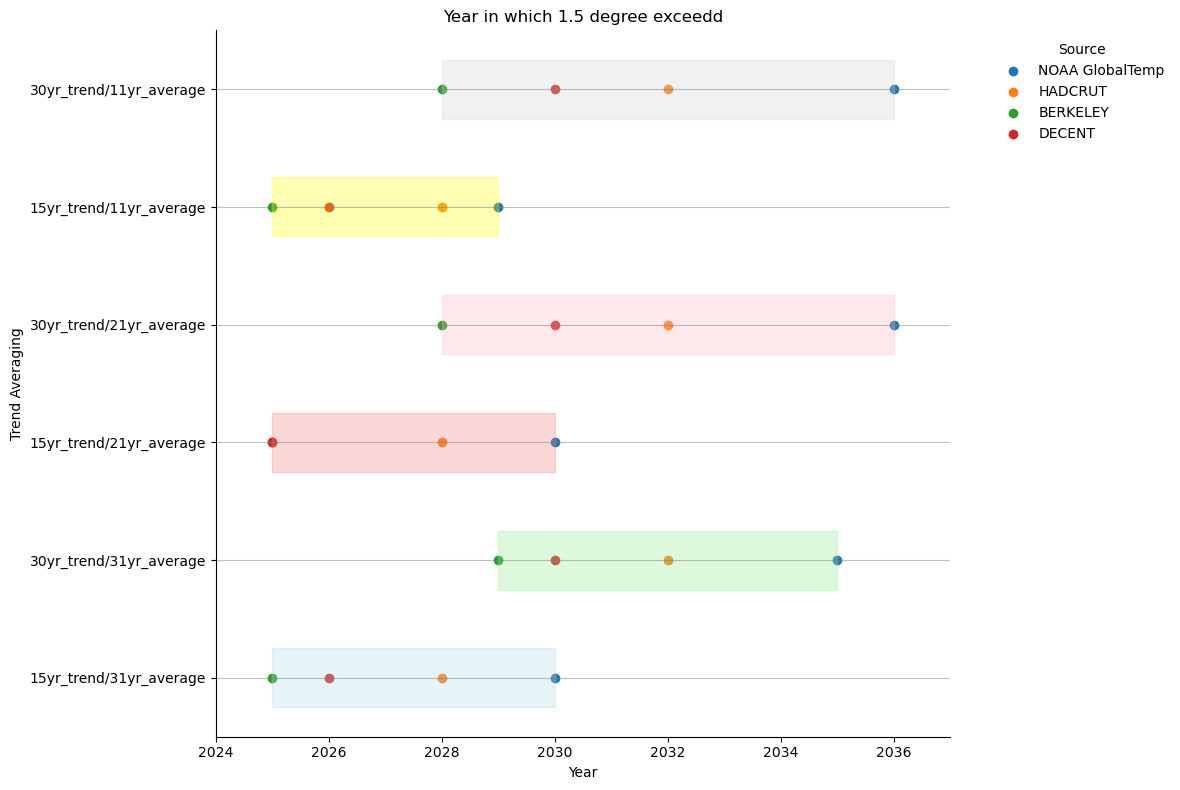

In [19]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define a color mapping for the trend averaging
color_mapping = {
    '15yr_trend/31yr_average': 'lightblue',
    '30yr_trend/31yr_average': 'lightgreen',
    '15yr_trend/21yr_average': 'lightcoral',
    '30yr_trend/21yr_average': 'lightpink',
    '15yr_trend/11yr_average': 'yellow',
    '30yr_trend/11yr_average': 'lightgray'
}

# Plot the data points
for source in df_trend_averaging['Source'].unique():
    df_source = df_trend_averaging[df_trend_averaging['Source'] == source]
    ax.scatter(df_source['Year'], df_source['Trend_Averaging'], label=source)

# Add shaded boxes
for trend_averaging in df_trend_averaging['Trend_Averaging'].unique():
    min_year = df_trend_averaging[df_trend_averaging['Trend_Averaging'] == trend_averaging]['Year'].min()
    max_year = df_trend_averaging[df_trend_averaging['Trend_Averaging'] == trend_averaging]['Year'].max()
    color = color_mapping.get(trend_averaging, 'lightgray')  # Default color if not found in mapping
    y_index = list(df_trend_averaging['Trend_Averaging'].unique()).index(trend_averaging)
    ax.add_patch(plt.Rectangle((min_year, y_index - 0.25), max_year - min_year, 0.5, color=color, alpha=0.3))

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Trend Averaging')
ax.set_title('Year in which 1.5 degree exceedd')

# Customize the plot
ax.grid(True, linestyle='-', alpha=0.5, axis='y', which='both', color='gray')
ax.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim([df_trend_averaging['Year'].min() - 1, df_trend_averaging['Year'].max() + 1])
ax.set_ylim([-0.5, len(df_trend_averaging['Trend_Averaging'].unique()) - 0.5])
ax.set_yticks(range(len(df_trend_averaging['Trend_Averaging'].unique())))
ax.set_yticklabels([str(label) for label in df_trend_averaging['Trend_Averaging'].unique()])
# Remove top and right box lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove legend box
ax.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

# Show the plot
plt.tight_layout()
plt.show()

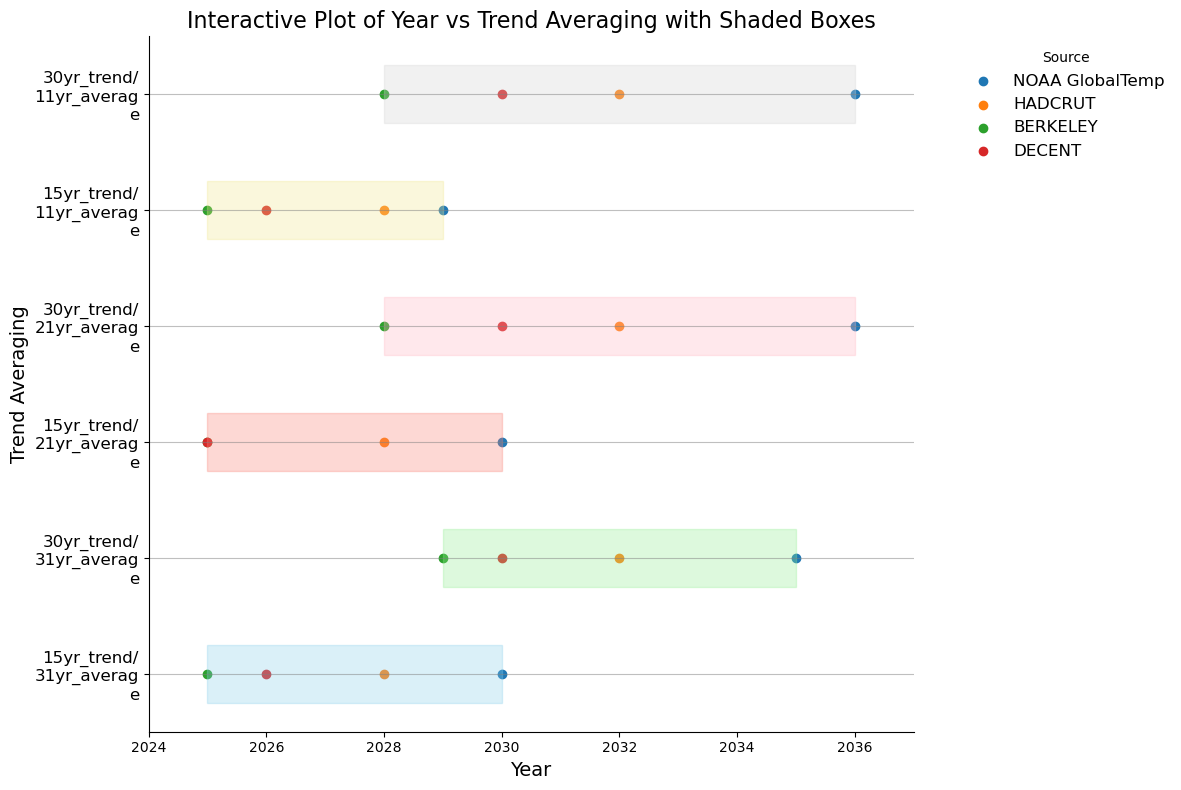

In [66]:
import textwrap

# Define a new color mapping with more vibrant colors
enhanced_color_mapping = {
    '15yr_trend/31yr_average': 'skyblue',
    '30yr_trend/31yr_average': 'lightgreen',
    '15yr_trend/21yr_average': 'salmon',
    '30yr_trend/21yr_average': 'lightpink',
    '15yr_trend/11yr_average': 'khaki',
    '30-yr_trend/11yr_average': 'silver'
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data points
for source in df_trend_averaging['Source'].unique():
    df_source = df_trend_averaging[df_trend_averaging['Source'] == source]
    ax.scatter(df_source['Year'], df_source['Trend_Averaging'], label=source)

# Add shaded boxes
for trend_averaging in df_trend_averaging['Trend_Averaging'].unique():
    min_year = df_trend_averaging[df_trend_averaging['Trend_Averaging'] == trend_averaging]['Year'].min()
    max_year = df_trend_averaging[df_trend_averaging['Trend_Averaging'] == trend_averaging]['Year'].max()
    color = enhanced_color_mapping.get(trend_averaging, 'lightgray')  # Default color if not found in mapping
    y_index = list(df_trend_averaging['Trend_Averaging'].unique()).index(trend_averaging)
    ax.add_patch(plt.Rectangle((min_year, y_index - 0.25), max_year - min_year, 0.5, color=color, alpha=0.3))

# Set labels and title
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Trend Averaging', fontsize=14)
ax.set_title('Interactive Plot of Year vs Trend Averaging with Shaded Boxes', fontsize=16)

# Customize the plot
ax.grid(True, linestyle='-', alpha=0.5, axis='y', which='both', color='gray')
ax.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=12)
ax.set_xlim([df_trend_averaging['Year'].min() - 1, df_trend_averaging['Year'].max() + 1])
ax.set_ylim([-0.5, len(df_trend_averaging['Trend_Averaging'].unique()) - 0.5])

# Wrap text in y-axis tick labels
wrapped_labels = [textwrap.fill(label, width=11, max_lines=3) for label in df_trend_averaging['Trend_Averaging'].unique()]
# wrapped_labels
ax.set_yticks(range(len(wrapped_labels)))
ax.set_yticklabels(wrapped_labels, fontsize=12)

# Remove top and right box lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

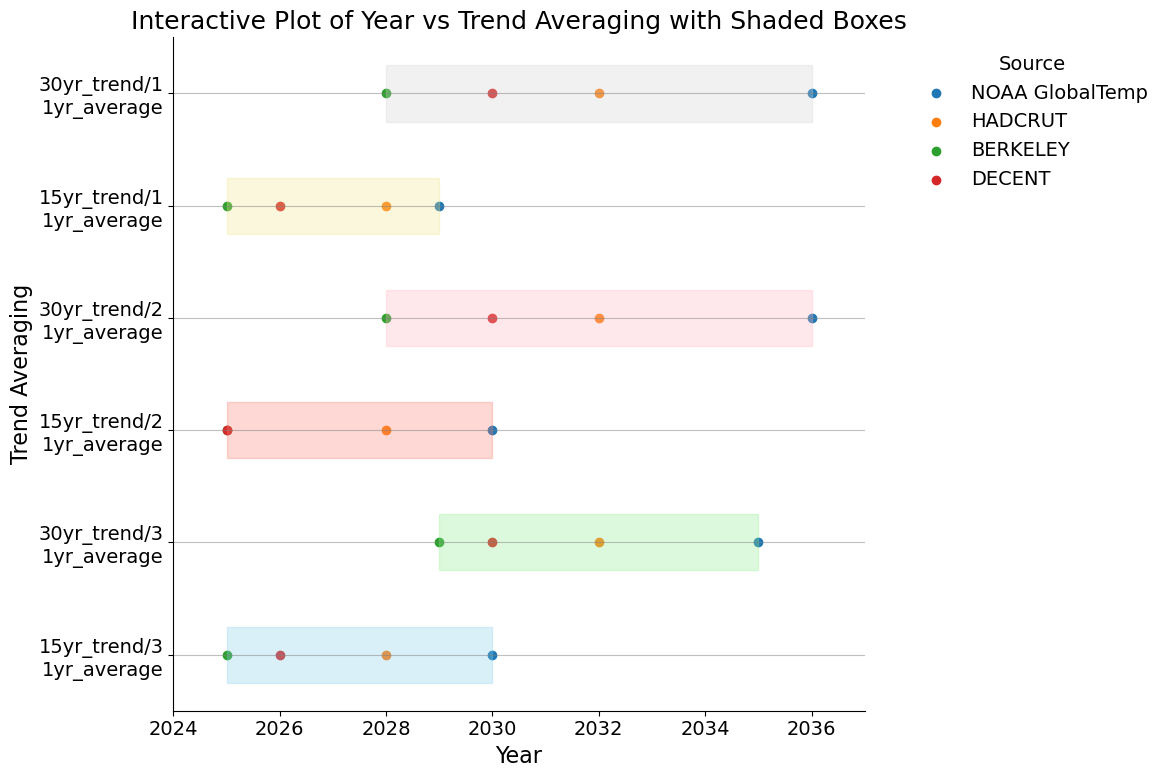

In [77]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
# matplotlib.font_manager._rebuild()
# Set font properties globally
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data points
for source in df_trend_averaging['Source'].unique():
    df_source = df_trend_averaging[df_trend_averaging['Source'] == source]
    ax.scatter(df_source['Year'], df_source['Trend_Averaging'], label=source)

# Add shaded boxes
for trend_averaging in df_trend_averaging['Trend_Averaging'].unique():
    min_year = df_trend_averaging[df_trend_averaging['Trend_Averaging'] == trend_averaging]['Year'].min()
    max_year = df_trend_averaging[df_trend_averaging['Trend_Averaging'] == trend_averaging]['Year'].max()
    color = enhanced_color_mapping.get(trend_averaging, 'lightgray')  # Default color if not found in mapping
    y_index = list(df_trend_averaging['Trend_Averaging'].unique()).index(trend_averaging)
    ax.add_patch(plt.Rectangle((min_year, y_index - 0.25), max_year - min_year, 0.5, color=color, alpha=0.3))

# Set labels and title
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Trend Averaging', fontsize=16)
ax.set_title('Interactive Plot of Year vs Trend Averaging with Shaded Boxes', fontsize=18)

# Customize the plot
ax.grid(True, linestyle='-', alpha=0.5, axis='y', which='both', color='gray')
ax.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=14)
ax.set_xlim([df_trend_averaging['Year'].min() - 1, df_trend_averaging['Year'].max() + 1])
ax.set_ylim([-0.5, len(df_trend_averaging['Trend_Averaging'].unique()) - 0.5])

# Wrap text in y-axis tick labels
wrapped_labels = [textwrap.fill(label, width=12, max_lines=2) for label in df_trend_averaging['Trend_Averaging'].unique()]
ax.set_yticks(range(len(wrapped_labels)))
ax.set_yticklabels(wrapped_labels, fontsize=14)

# Remove top and right box lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()